<a href="https://colab.research.google.com/github/tanmy-sharma/DiabetesPrediction/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Prediction 

In this notebook, I would like to test out a diabetes dataset in order to accurately predict whether or not the person has diabetes by the state of their health factors provided in the dataset.

## Load Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report

### Reading the dataset

In [3]:
df = pd.read_csv('/content/diabetes_binary.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA

Checking for empty values

In [4]:
[features for features in df.columns if df[features].isnull().sum() > 0]

[]

<Axes: >

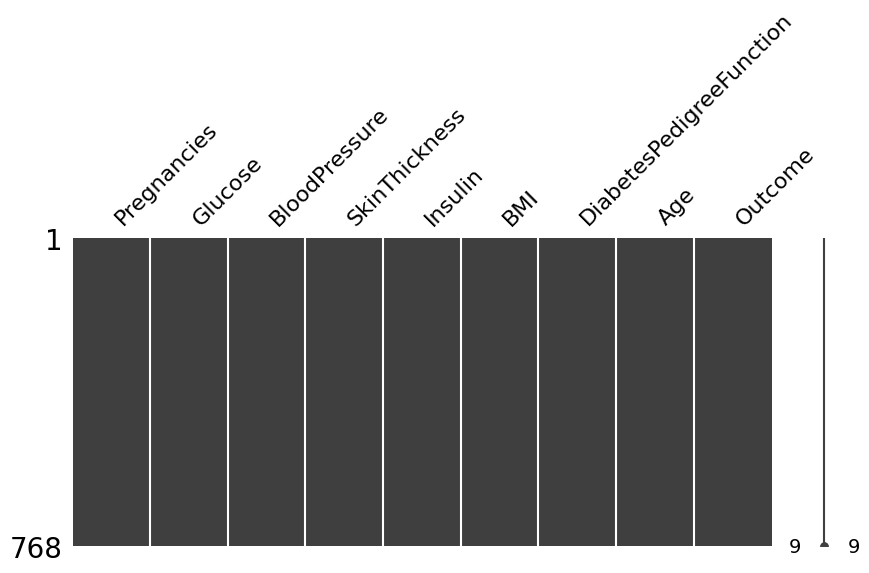

In [5]:
# another way to give a visual representation

import missingno as msno
msno.matrix(df, figsize = (10,4))

As we can see from above, we have **no missing data**.

### Checking target Imbalance

In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

([<matplotlib.patches.Wedge at 0x7ff929f88ca0>,
 [Text(-0.5025943242672991, 0.9784676515931925, '0'),
  Text(0.5025944158780503, -0.9784676045369114, '1')],
 [Text(-0.27414235869125403, 0.5337096281417413, '65.1%'),
  Text(0.2741424086607547, -0.5337096024746789, '34.9%')])

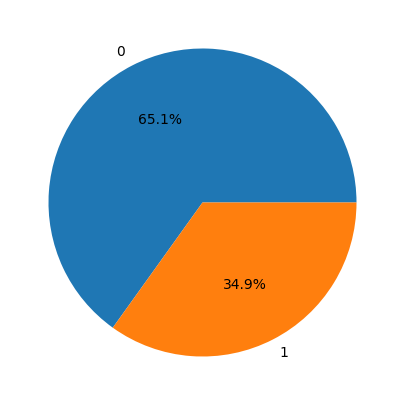

In [7]:
plt.figure(figsize = (5,5))
plt.pie(df['Outcome'].value_counts().values, autopct='%1.1f%%', labels = df['Outcome'].value_counts().index)

**Data is balanced.**

## Checking Statistics

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We can see that some of the minimum values of the columns like Glucose, Skin Thickness is zero, which should not be zero. So, I am going to replace all the values of zero to the mean of the concerned column.

In [9]:
zero_columns = []

for column in df.columns:
  if df[column][df[column] == 0].count() > 0:
    zero_columns.append(column)

zero_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'Outcome']

These columns have 0 in their values but pregnancies can be zero, so we will remove that. Outcome is 0 and 1, so we need to remove that column as well.

In [10]:
zero_columns.remove('Pregnancies')
zero_columns.remove('Outcome')
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Replacing 0's with mean values

In [11]:
diabetes_zero_median = df[zero_columns].median()
df[zero_columns] = df[zero_columns].replace(0, diabetes_zero_median)

In [12]:
for column in df.columns:
  if df[column][df[column] == 0].count() > 0:
    print(column)

Pregnancies
Outcome


In [13]:
df[zero_columns].median()

Glucose          117.00
BloodPressure     72.00
SkinThickness     23.00
Insulin           31.25
BMI               32.00
dtype: float64

Checking graphs of all features 

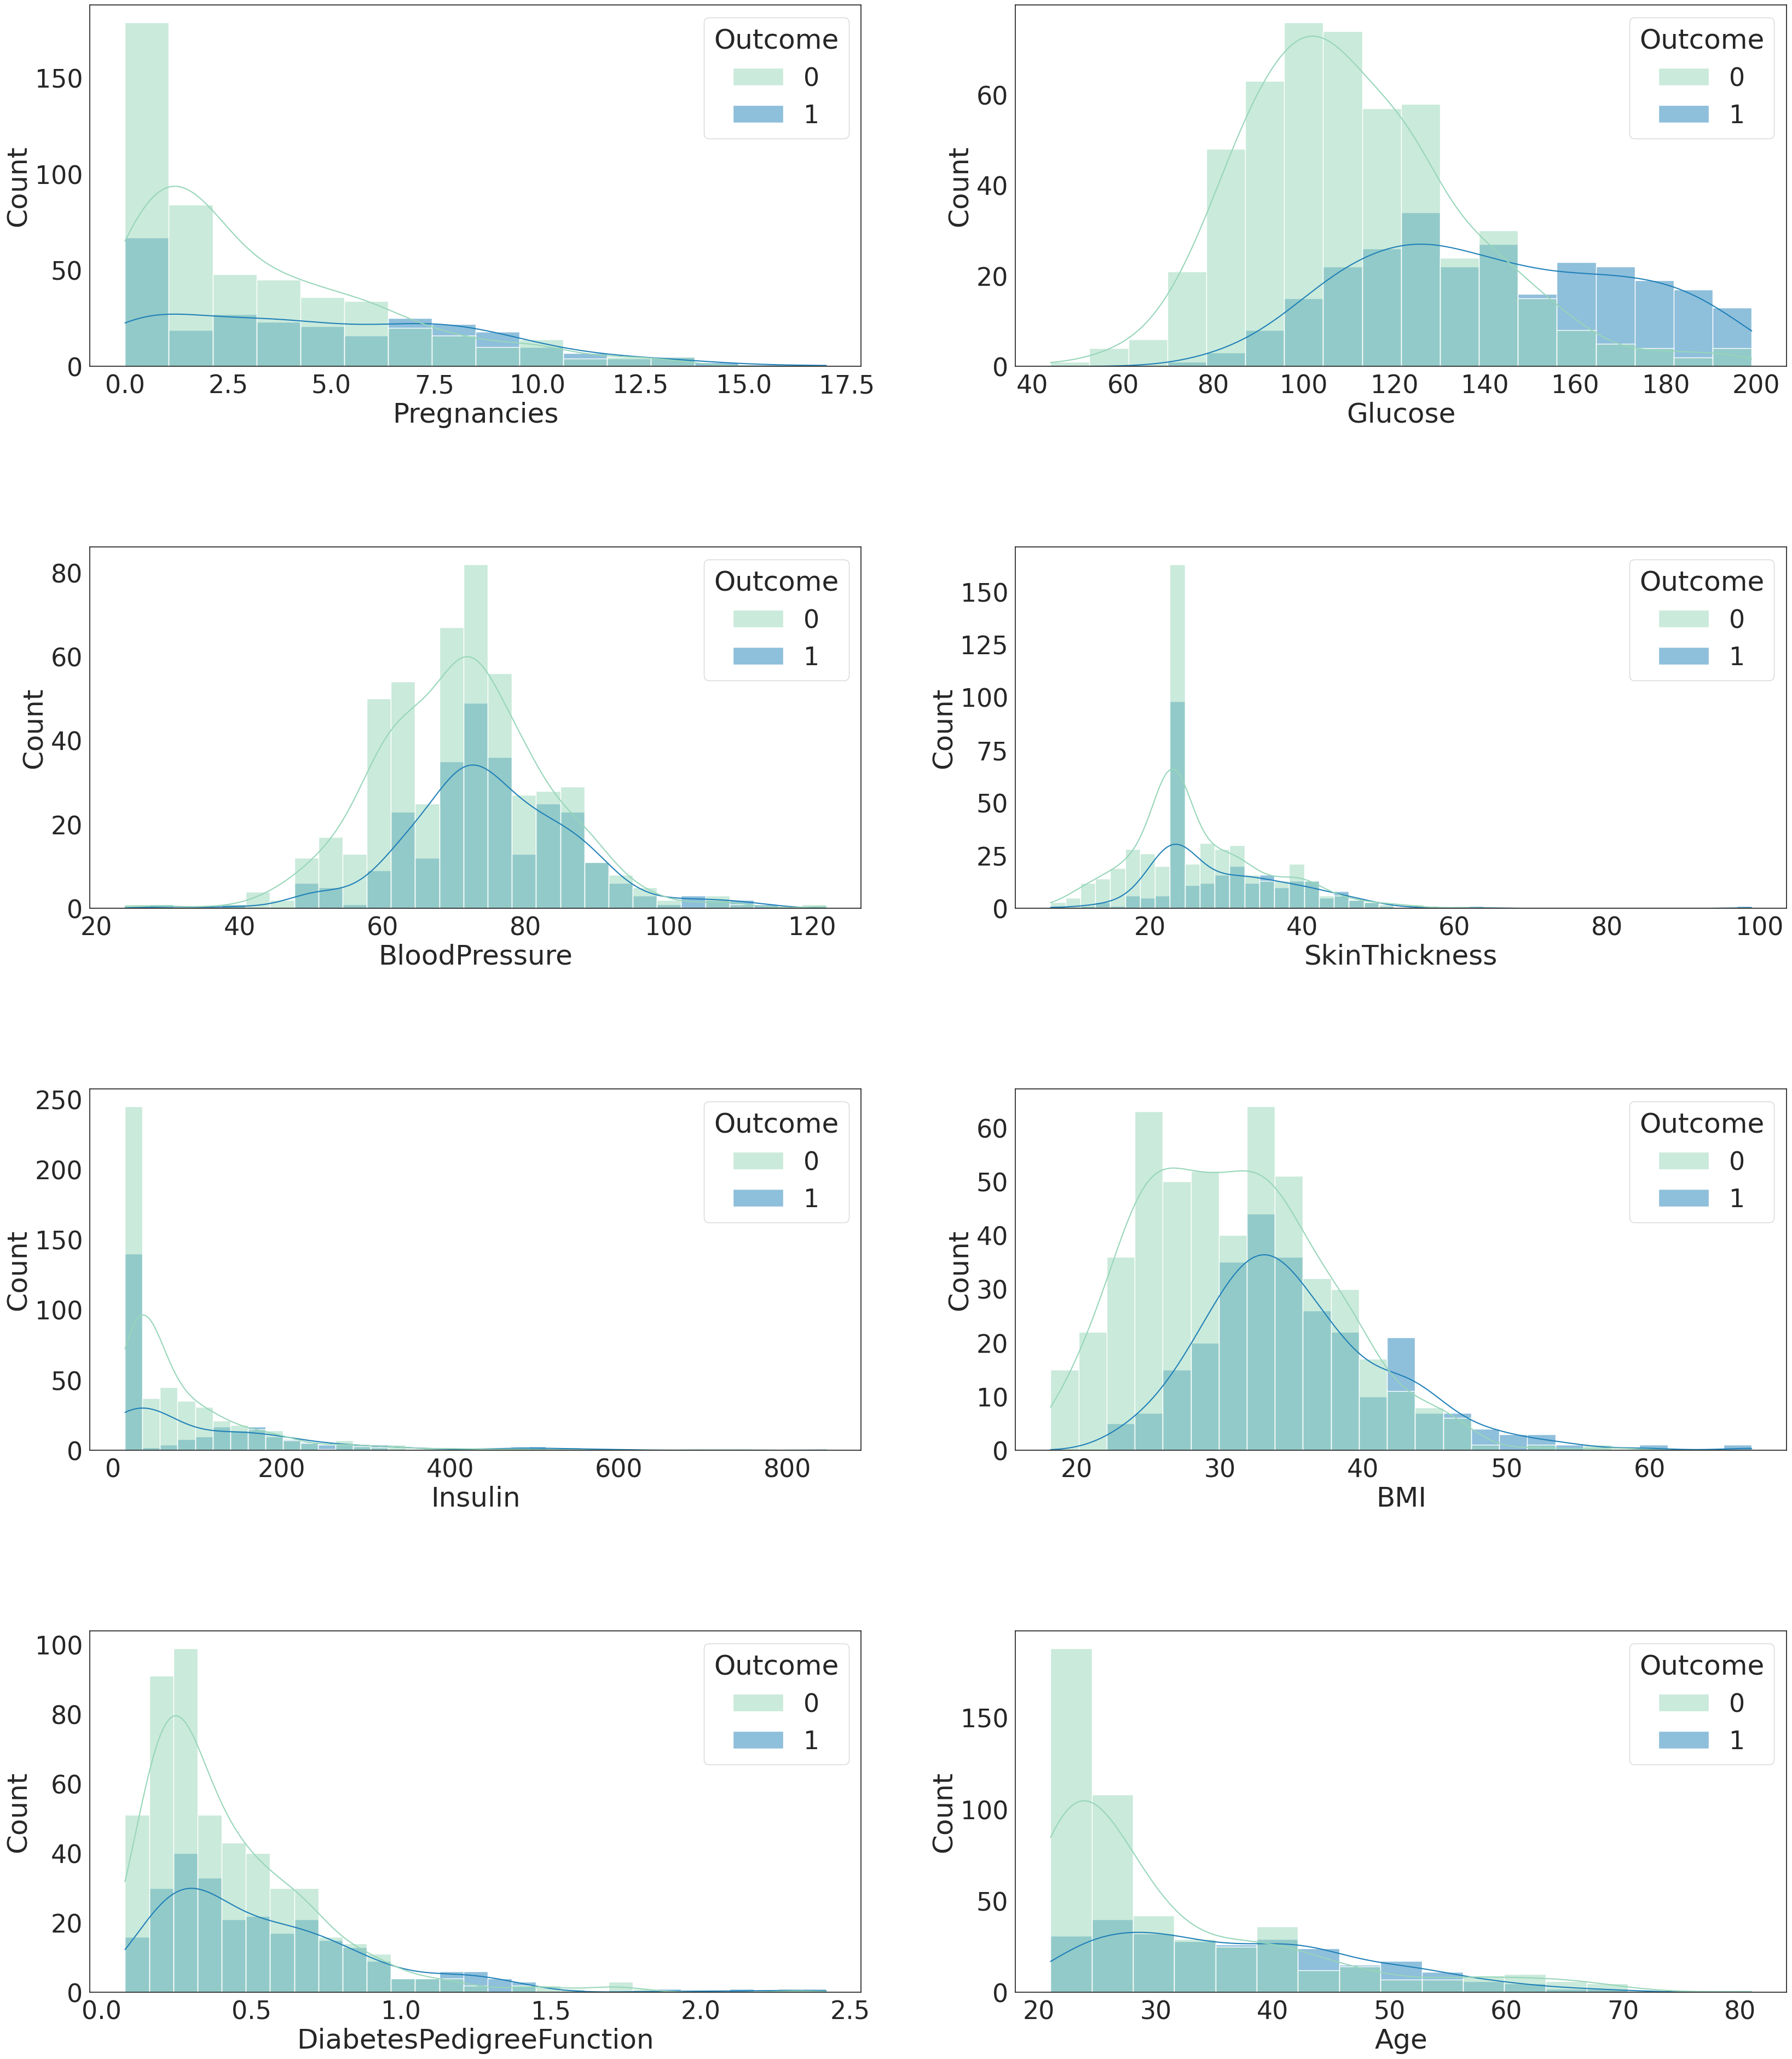

In [14]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for columns in df.columns:
  if columns != 'Outcome':
      plt.subplot(5,2,i)
      sns.histplot(data=df, x=columns, hue="Outcome",kde=True,palette="YlGnBu")
      i = i + 1

### Checking the co-relation between features

<ipython-input-49-a09cfe02c21a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


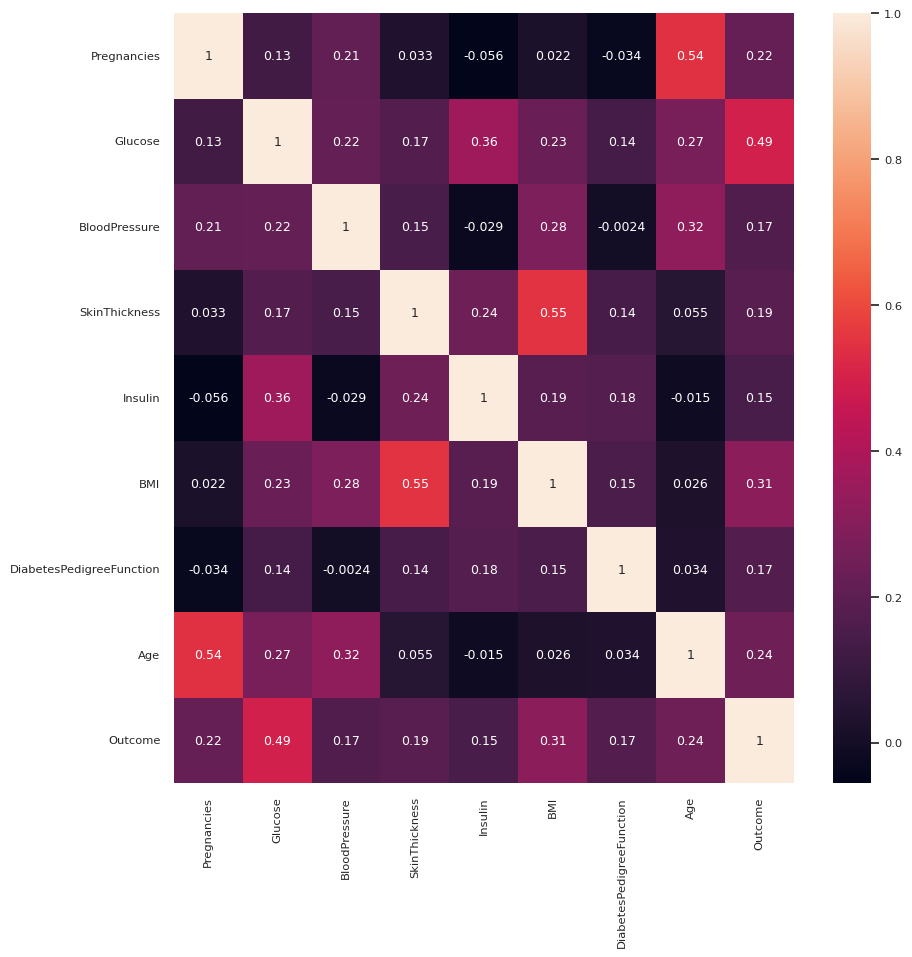

In [49]:
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), annot = True)
sns.set(font_scale=0.5)
plt.show()

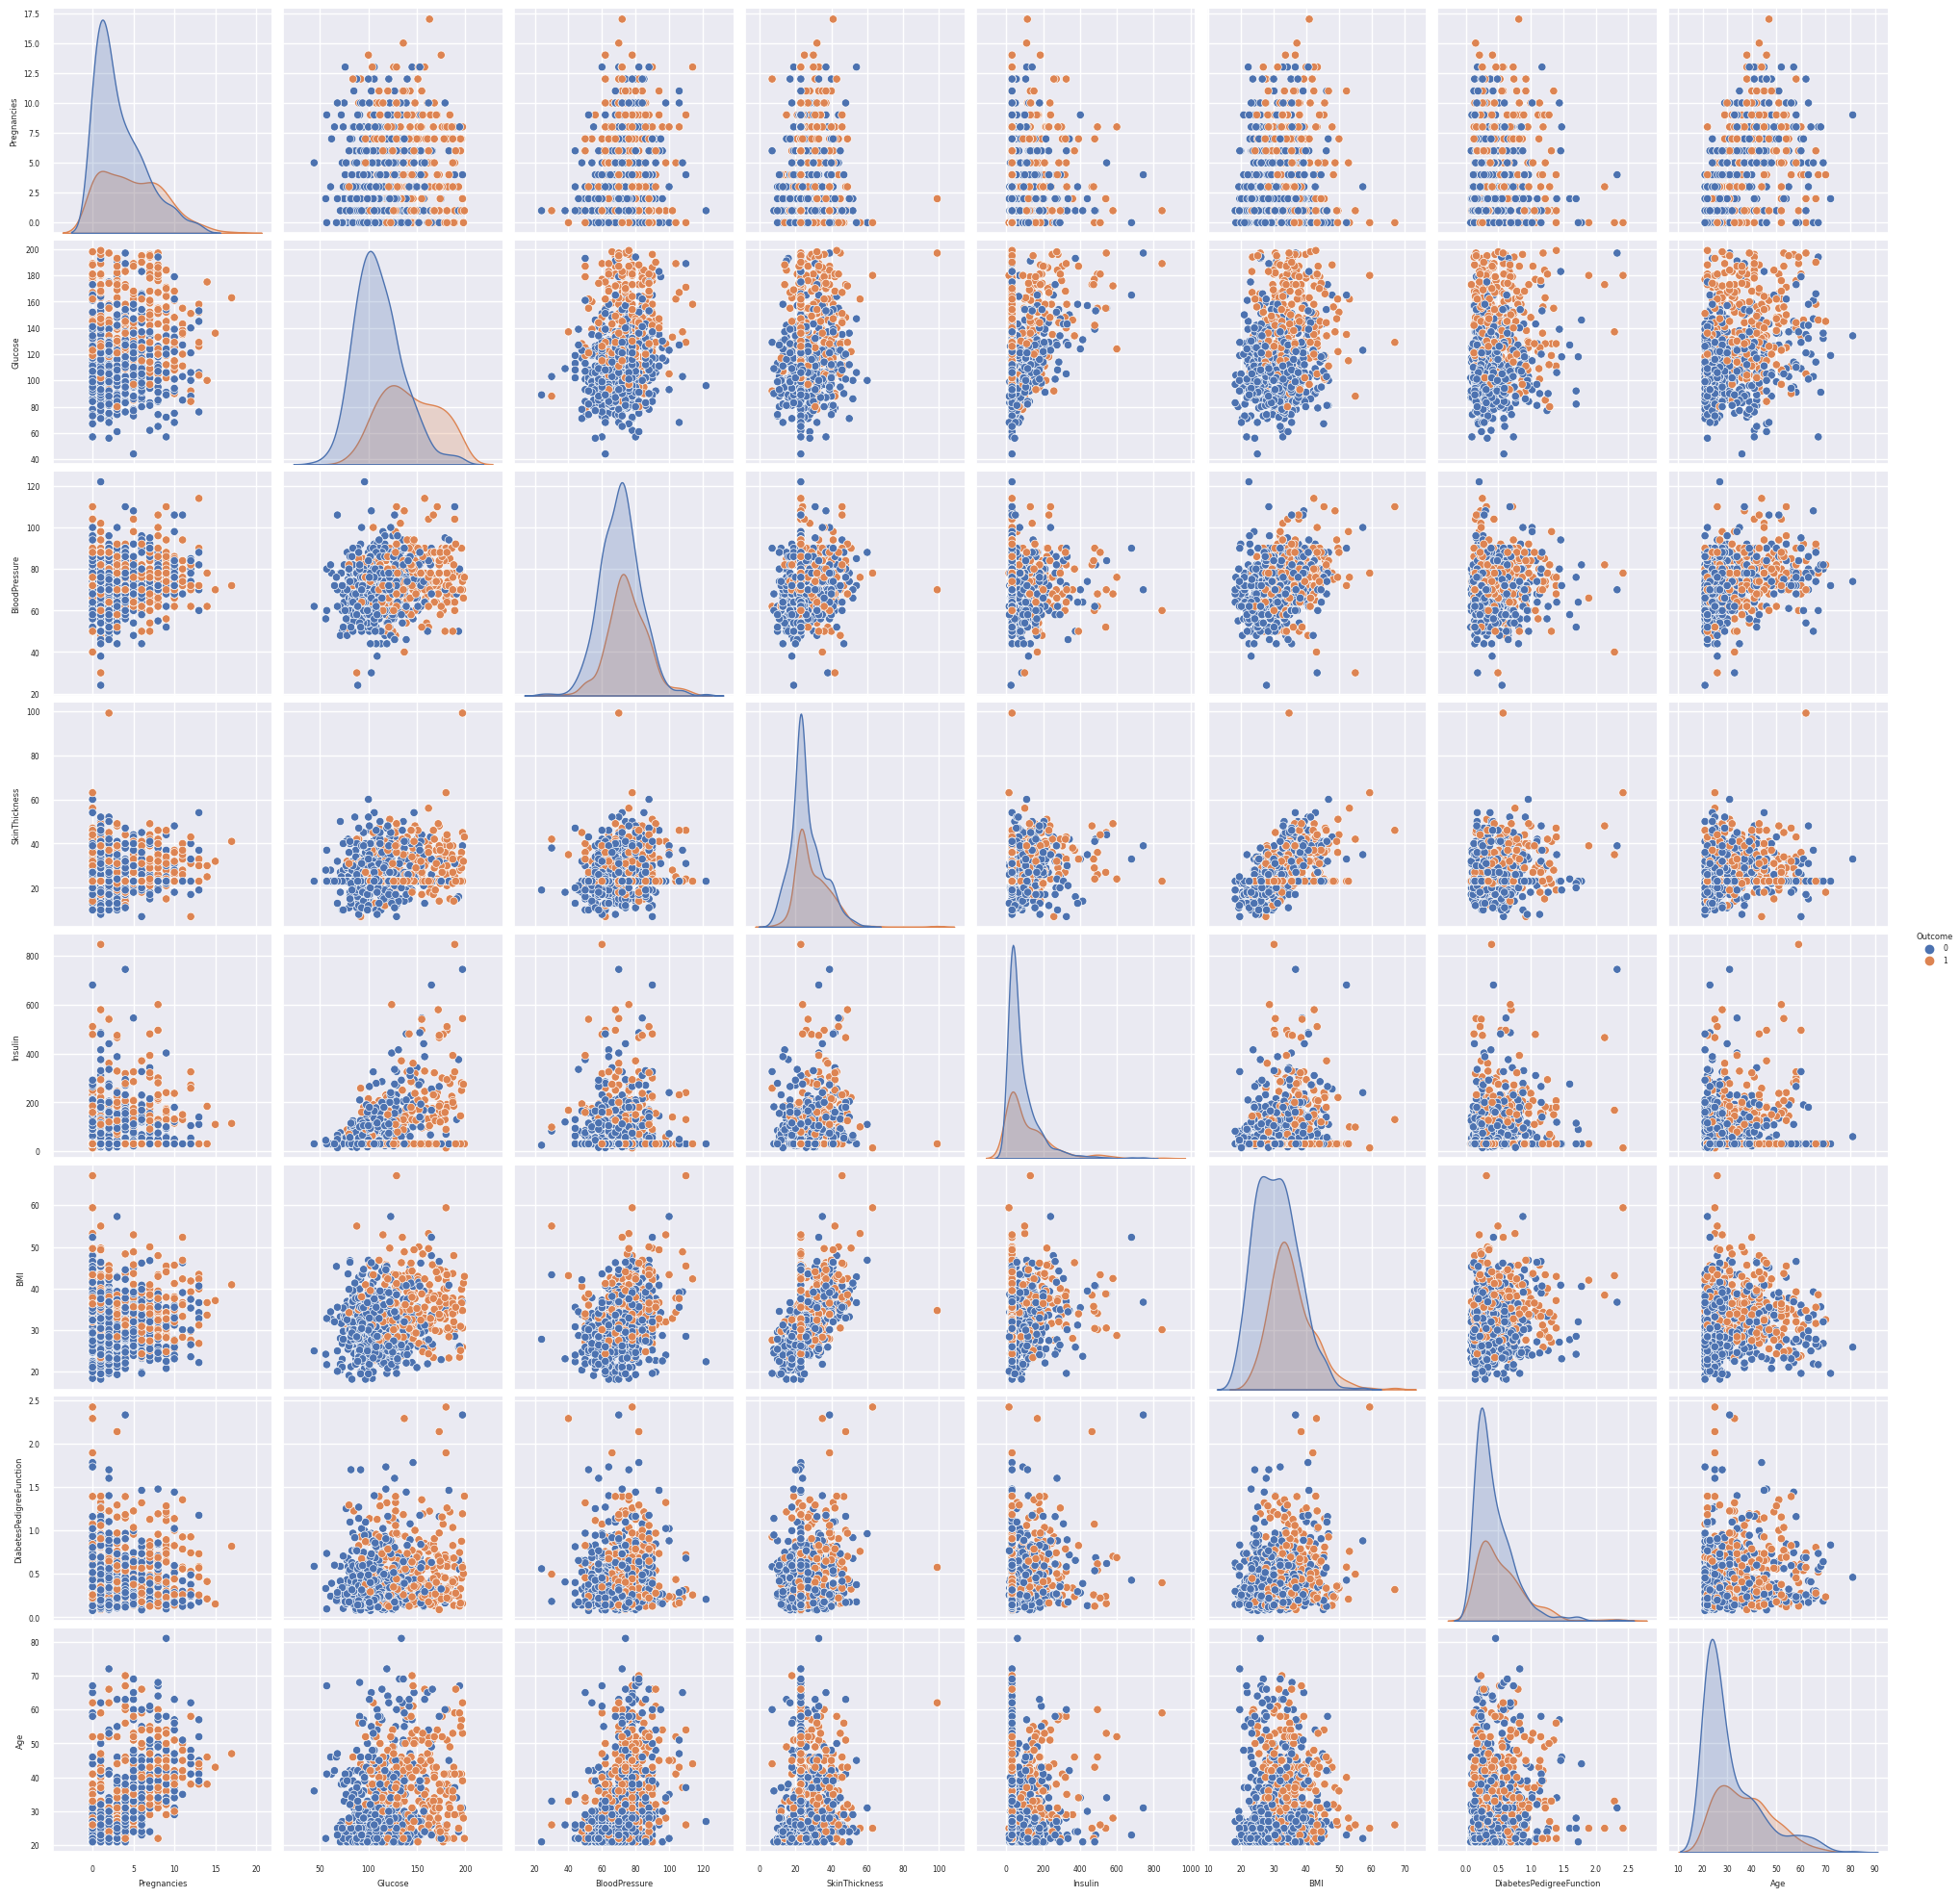

In [16]:
plt.rcParams.update({'font.size': 10})
sns.set(font_scale=0.5)
sns.pairplot(df, hue = 'Outcome')
plt.show()

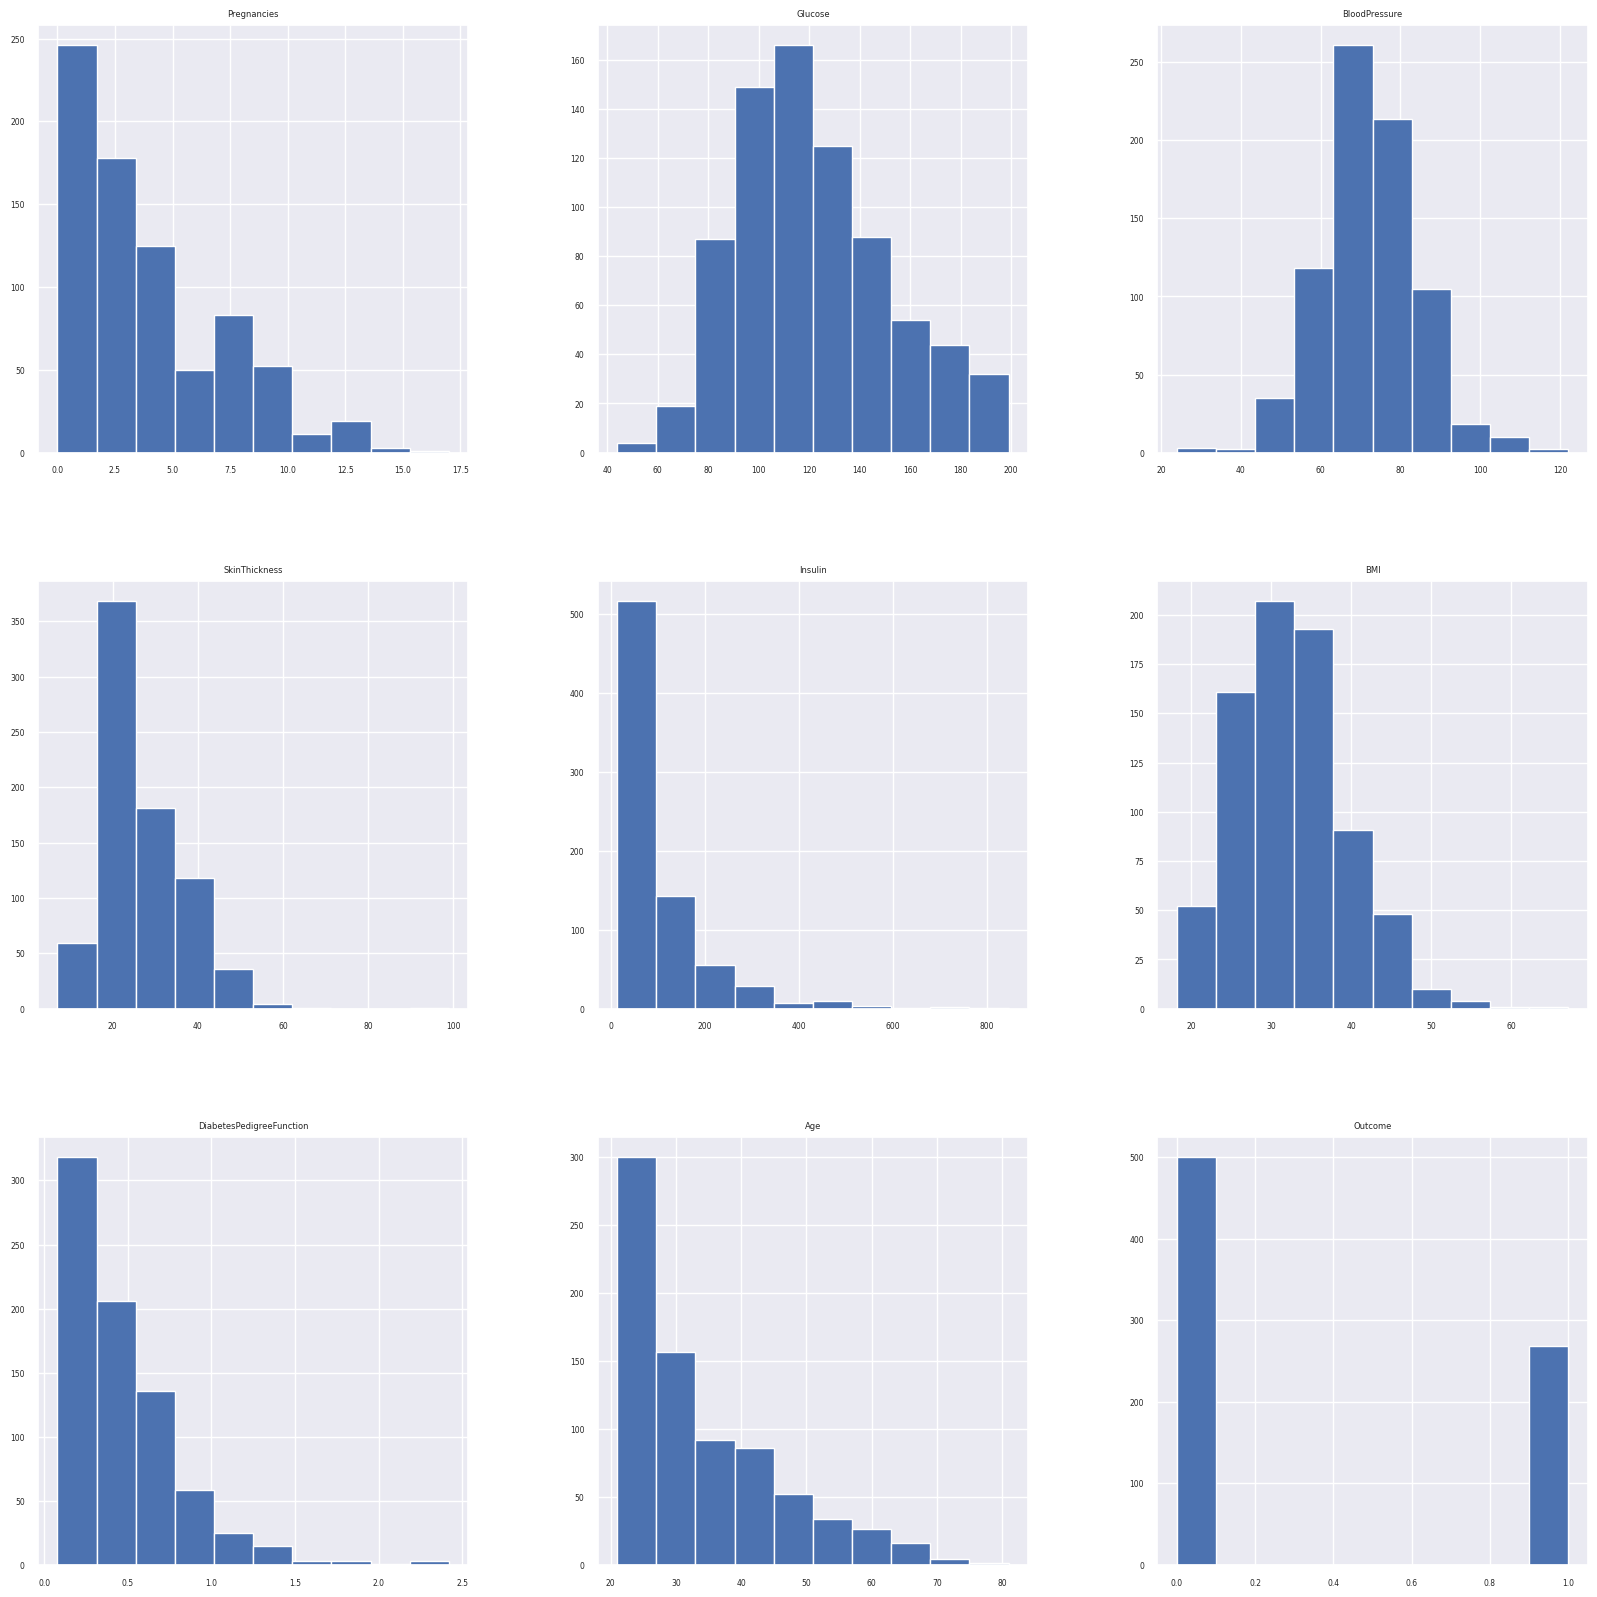

In [17]:
df.hist(figsize = (20,20))
sns.set(font_scale=0.75)

## Observations:

1. Given the correlation of glucose and outcome is high, Glucose might be the most important aspect in the dataset.

2. Skin Thickness, BMI, and Diabetes Pedigree Function seems to be related to each other.

3. After glucose, BMI, age and number of pregnancies seem to be of importance.

## Checking for Outliers

Pregnancies                    Axes(0.125,0.653529;0.227941x0.226471)
Glucose                     Axes(0.398529,0.653529;0.227941x0.226471)
BloodPressure               Axes(0.672059,0.653529;0.227941x0.226471)
SkinThickness                  Axes(0.125,0.381765;0.227941x0.226471)
Insulin                     Axes(0.398529,0.381765;0.227941x0.226471)
BMI                         Axes(0.672059,0.381765;0.227941x0.226471)
DiabetesPedigreeFunction           Axes(0.125,0.11;0.227941x0.226471)
Age                             Axes(0.398529,0.11;0.227941x0.226471)
Outcome                         Axes(0.672059,0.11;0.227941x0.226471)
dtype: object

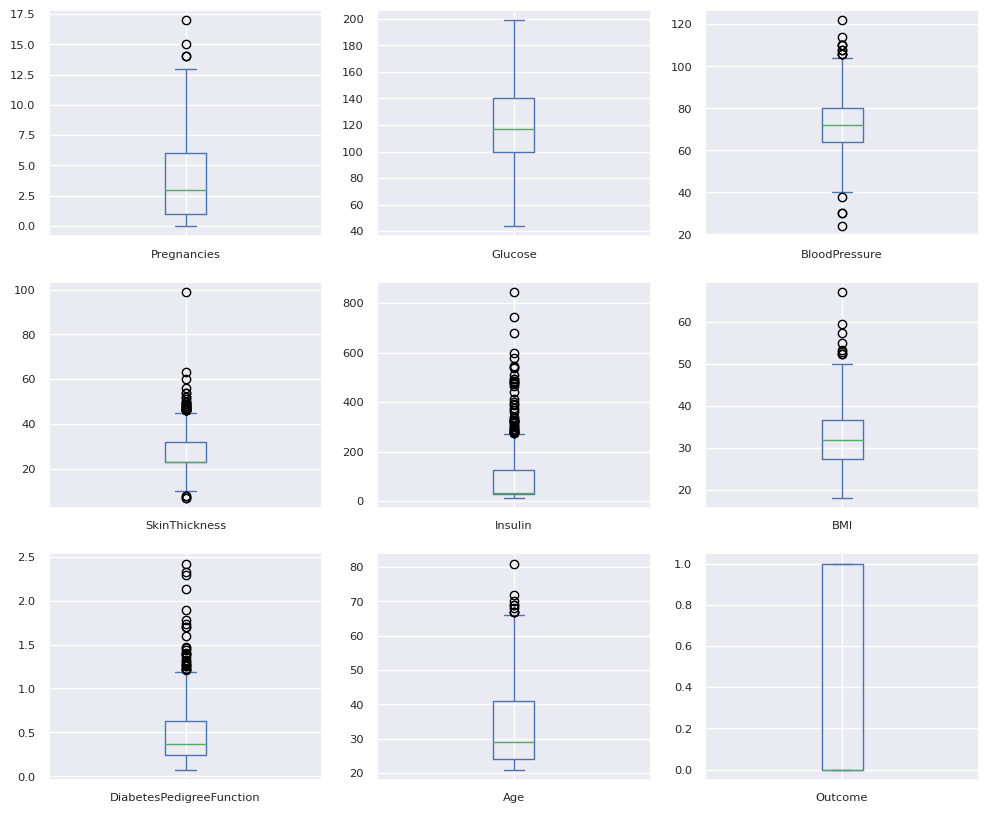

In [18]:
# Plot the boxplot for checking the outliers
df.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12,10))

Outliers are present in some features.

#  Feature Engineering

**Glucose**

* Glucose > 130 -> Pre Diabetic
* Glucose < 130 -> Normal

In [19]:
df['Glucose_classification'] = pd.cut(x=df['Glucose'], bins=[0,129,200],labels = ["Normal","Prediabetic"])
df['Glucose_classification'].value_counts()

Normal         510
Prediabetic    258
Name: Glucose_classification, dtype: int64

**BMI**

* < 18.5 -> Under Weight -> UW
* < 25 -> Normal -> N
* < 30 -> Over Weight -> OW
* (30 <) -> Obsese -> OO


In [20]:
df['BMI_classification'] = pd.cut(x=df['BMI'], bins=[0,18.5,24.9,29.9,100],labels = ["UW","N","OW","OO"])
df['BMI_classification'].value_counts()

OO    483
OW    179
N     102
UW      4
Name: BMI_classification, dtype: int64

**Blood Pressure**

* < 80 : Normal
* < 100 : high_1
* < 123 : high_2

In [21]:
df['BloodPressure_classification'] = pd.cut(x=df['BloodPressure'], bins=[0,79,99,123],labels = ["Normal","High_1","High_2"])
df['BloodPressure_classification'].value_counts()

Normal    563
High_1    189
High_2     16
Name: BloodPressure_classification, dtype: int64

## Spliting data

* We are going one hot encode our new introduced features.
* Rest of the features, we are going to use Robust Scaler to deal with the outliers.

In [22]:
x = df.drop(columns = 'Outcome', axis = 1)
y = df['Outcome']
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Pregnancies                   768 non-null    int64   
 1   Glucose                       768 non-null    int64   
 2   BloodPressure                 768 non-null    int64   
 3   SkinThickness                 768 non-null    int64   
 4   Insulin                       768 non-null    float64 
 5   BMI                           768 non-null    float64 
 6   DiabetesPedigreeFunction      768 non-null    float64 
 7   Age                           768 non-null    int64   
 8   Glucose_classification        768 non-null    category
 9   BMI_classification            768 non-null    category
 10  BloodPressure_classification  768 non-null    category
dtypes: category(3), float64(3), int64(5)
memory usage: 50.8 KB


In [23]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 768 entries, 0 to 767
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


**Preprocessing the data**

In [24]:
lst_new_features = ['Glucose_classification', 'BMI_classification', 'BloodPressure_classification']
lst_other_features = [columns for columns in x.columns if columns not in lst_new_features]
lst_other_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [25]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

In [26]:
x, new_columns_created = one_hot_encoder(x, lst_new_features)
new_columns_created

['Glucose_classification_Prediabetic',
 'BMI_classification_N',
 'BMI_classification_OW',
 'BMI_classification_OO',
 'BloodPressure_classification_High_1',
 'BloodPressure_classification_High_2']

In [27]:
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose_classification_Prediabetic,BMI_classification_N,BMI_classification_OW,BMI_classification_OO,BloodPressure_classification_High_1,BloodPressure_classification_High_2
0,6,148,72,35,30.5,33.6,0.627,50,1,0,0,1,0,0
1,1,85,66,29,30.5,26.6,0.351,31,0,0,1,0,0,0
2,8,183,64,23,30.5,23.3,0.672,32,1,1,0,0,0,0
3,1,89,66,23,94.0,28.1,0.167,21,0,0,1,0,0,0
4,0,137,40,35,168.0,43.1,2.288,33,1,0,0,1,0,0


In [28]:
x = RobustScaler().fit_transform(x)

**Splitting it**

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 10, stratify = y, test_size = 0.2)

We have our training and testing data now. Time to train some models.

## Model Training

So, let's train a few models and see how they perform

## **Evaluation Criteria**

We are going to use three metrics based on confusion matrix in order to evaluate our model. 

### Confusion Matrix

* true positive (TP) : Diabetic correctly identified as diabetic
* true negative (TN) : Healthy correctly identified as healthy
* false positive (FP) : Healthy incorrectly identified as diabetic
* false negative (FN) : Diabetic incorrectly identified as healthy

### Metrics for evaluation

* Accuracy : (TP + TN) / ( TP + TN + FP + FN)
* Reacll : (TP) / (TP + FN)
* Precision : (TP) / (TP + FP)
* F1 Score : (2 * precision * recall) / (precision * recall)


In [30]:
dict_f1 = {}
dict_accuracy = {}
dict_recall = {}
dict_precision = {}

**Logistic Regression**

In [31]:
model_lr = LogisticRegression().fit(x_train, y_train)
lr_pred = model_lr.predict(x_test)

In [32]:
dict_accuracy['LR'] = accuracy_score(y_test, lr_pred)
dict_f1['LR'] = recall_score(y_test, lr_pred)
dict_recall['LR'] = f1_score(y_test, lr_pred)
dict_precision['LR'] = precision_score(y_test, lr_pred)

print("Accuracy : ", dict_accuracy['LR'])
print("Recall : ", dict_recall['LR'])
print("Precision :", dict_precision['LR'])
print("F1 : ", dict_f1['LR'])

Accuracy :  0.8181818181818182
Recall :  0.7307692307692308
Precision : 0.76
F1 :  0.7037037037037037


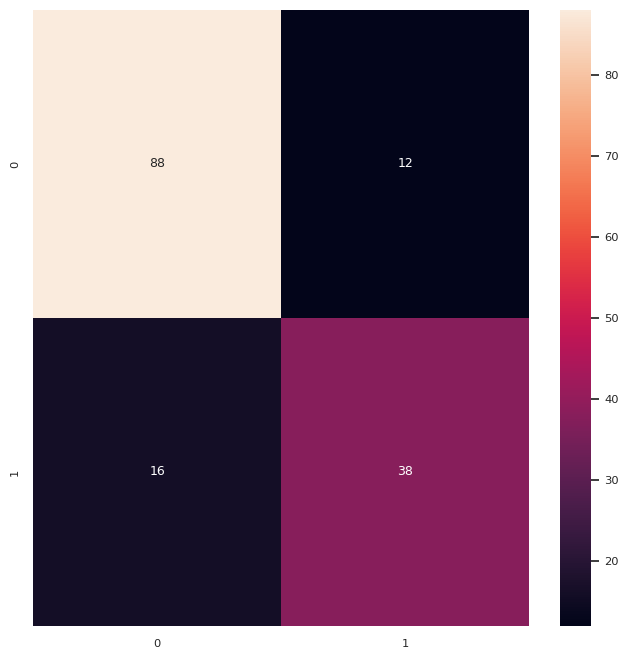

In [33]:
# plotting counfusion metric for Logistic Regression

plt.figure(figsize=(8, 8 ))
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True)
plt.show()

**Support Vector Machine(SVM)**

In [34]:
model_svm = SVC().fit(x_train, y_train)
svm_predict = model_svm.predict(x_test)

In [35]:
dict_accuracy['SVM'] = accuracy_score(y_test, svm_predict)
dict_f1['SVM'] = recall_score(y_test, svm_predict)
dict_recall['SVM'] = f1_score(y_test, svm_predict)
dict_precision['SVM'] = precision_score(y_test, svm_predict)

print("Accuracy : ", dict_accuracy['SVM'])
print("Recall : ", dict_recall['SVM'])
print("Precision :", dict_precision['SVM'])
print("F1 : ", dict_f1['SVM'])

Accuracy :  0.8116883116883117
Recall :  0.7010309278350516
Precision : 0.7906976744186046
F1 :  0.6296296296296297


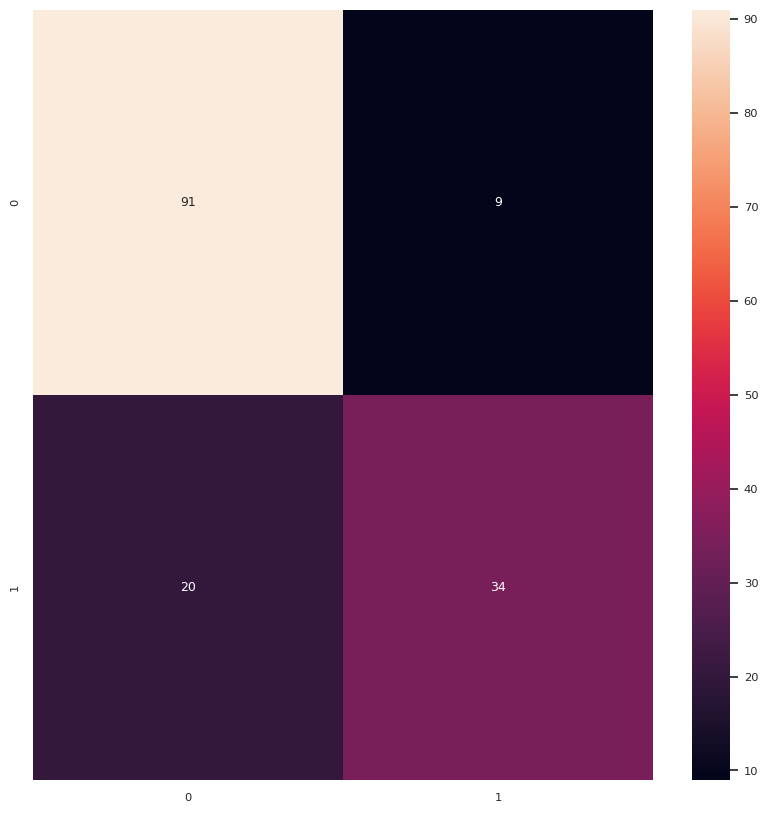

In [36]:
# printing confusion metric for SVM Model

plt.figure(figsize = (10, 10))
svm_cf = confusion_matrix(y_test, svm_predict)
sns.heatmap(svm_cf, annot = True)
plt.show()

**K Nearest Neighbours(KNN)**

In [37]:
model_knn = KNeighborsClassifier().fit(x_train, y_train)
knn_predict = model_knn.predict(x_test)

In [38]:
dict_accuracy['KNN'] = accuracy_score(y_test, knn_predict)
dict_precision['KNN'] = precision_score(y_test, knn_predict)
dict_recall['KNN'] = recall_score(y_test, knn_predict)
dict_f1['KNN'] = f1_score(y_test, knn_predict)

print("Accuracy :", dict_accuracy['KNN'])
print("Recall :", dict_recall['KNN'])
print("Precision :", dict_precision['KNN'])
print("F1 Score :", dict_f1['KNN'])

Accuracy : 0.7532467532467533
Recall : 0.6481481481481481
Precision : 0.6481481481481481
F1 Score : 0.6481481481481481


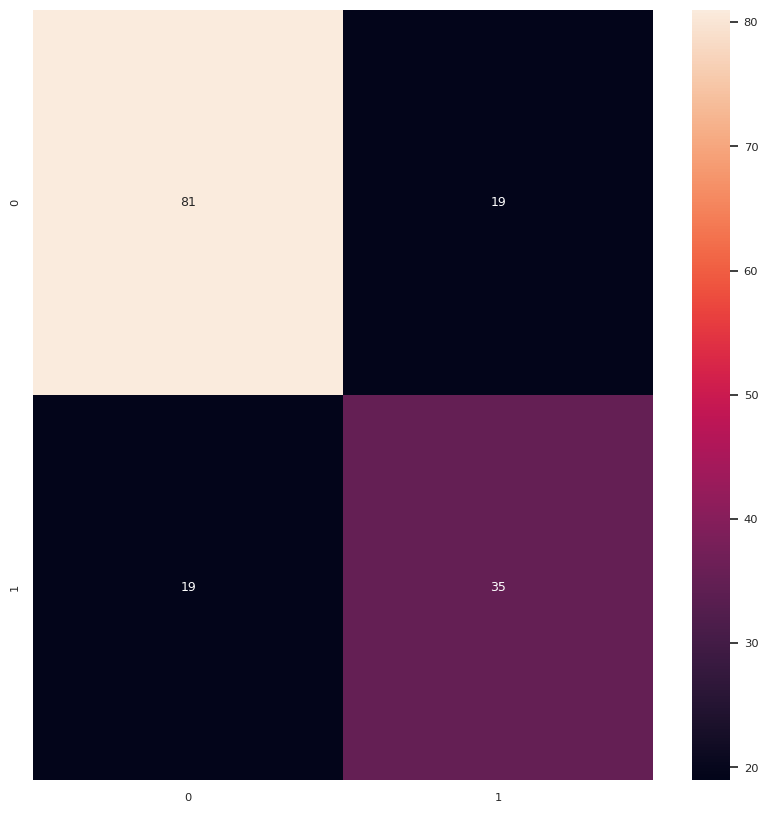

In [39]:
# printing confusion metric for KNN

plt.figure(figsize = (10,10))
knn_cf = confusion_matrix(y_test, knn_predict)
sns.heatmap(knn_cf, annot = True)
plt.show()

**Naive Bayers**

In [40]:
model_NB = GaussianNB().fit(x_train, y_train)
NB_predict = model_NB.predict(x_test)

In [41]:
dict_accuracy['NB'] = accuracy_score(y_test, NB_predict)
dict_recall['NB'] = recall_score(y_test, NB_predict)
dict_precision['NB'] = precision_score(y_test, NB_predict)
dict_f1['NB'] = f1_score(y_test, NB_predict)

print("Accuracy :", dict_accuracy['NB'])
print("Recall :", dict_recall['NB'])
print("Precision :", dict_precision['NB'])
print("F1 Score :", dict_f1['NB'])

Accuracy : 0.7792207792207793
Recall : 0.7592592592592593
Precision : 0.6612903225806451
F1 Score : 0.7068965517241378


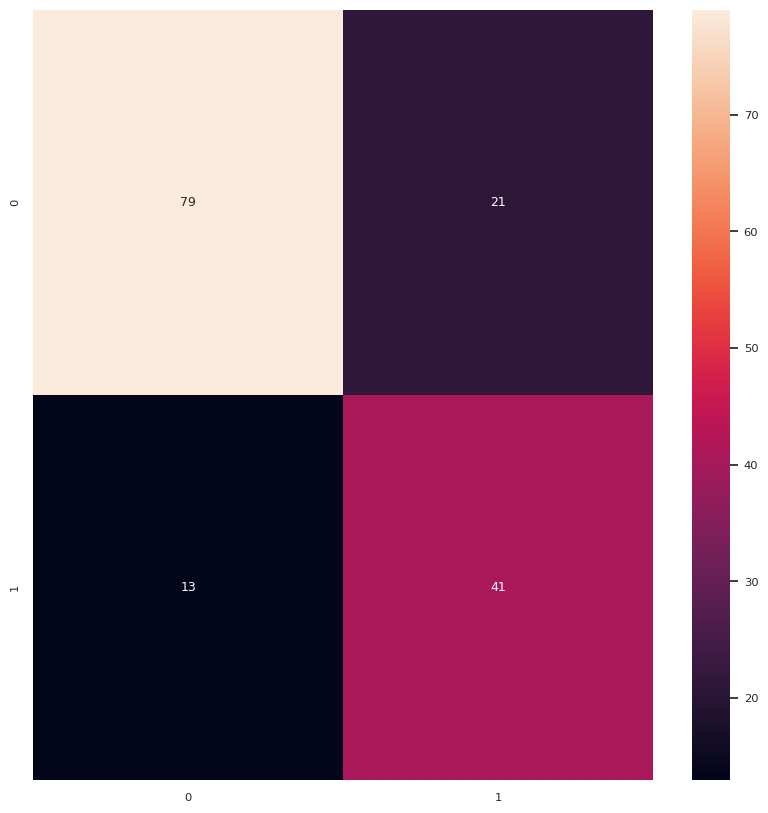

In [42]:
# printing confusion metic for Naive Bayers

plt.figure(figsize = (10,10))
NB_cf = confusion_matrix(y_test, NB_predict)
sns.heatmap(NB_cf, annot = True)
plt.show()

**Decision Trees**

In [43]:
model_DT = DecisionTreeClassifier(max_depth = 3, random_state = 50).fit(x_train, y_train)
DT_predict = model_DT.predict(x_test)

In [44]:
dict_accuracy['DT'] = accuracy_score(y_test, DT_predict)
dict_precision['DT'] = precision_score(y_test, DT_predict)
dict_recall['DT'] = recall_score(y_test, DT_predict)
dict_f1['DT'] = f1_score(y_test, DT_predict)

print("Accuracy :", dict_accuracy['DT'])
print("Precision :", dict_precision['DT'])
print("Recall :", dict_recall['DT'])
print("F1 Score : ", dict_f1['DT'])

Accuracy : 0.7987012987012987
Precision : 0.7346938775510204
Recall : 0.6666666666666666
F1 Score :  0.6990291262135923


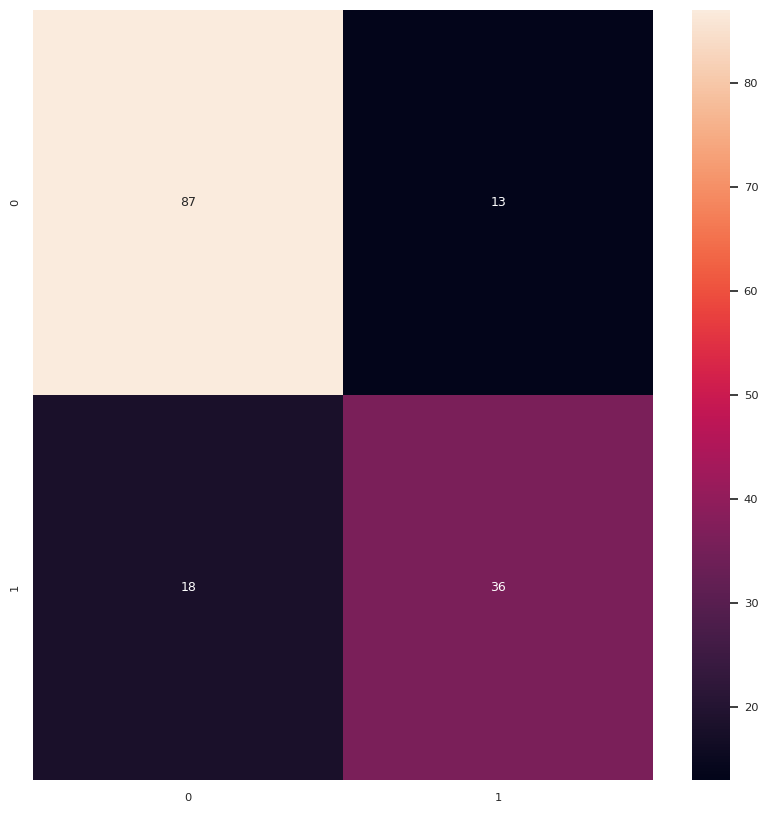

In [45]:
# printing the confusion metric for Decision Trees

plt.figure(figsize = (10, 10))
DT_cf = confusion_matrix(y_test, DT_predict)
sns.heatmap(DT_cf, annot = True)
plt.show()

**Random Forest**

In [46]:
model_RF = RandomForestClassifier(n_estimators = 50, random_state = 42).fit(x_train, y_train)
RF_predict = model_RF.predict(x_test)

In [47]:
dict_accuracy['RF'] = accuracy_score(y_test, RF_predict)
dict_precision['RF'] = precision_score(y_test, RF_predict)
dict_recall['RF'] = recall_score(y_test, RF_predict)
dict_f1['RF'] = f1_score(y_test, RF_predict)

print("Accuracy :", dict_accuracy['RF'])
print("Precision :", dict_precision['RF'])
print("Recall :", dict_recall['RF'])
print("F1 Score :", dict_f1['RF'])

Accuracy : 0.7857142857142857
Precision : 0.7058823529411765
Recall : 0.6666666666666666
F1 Score : 0.6857142857142857


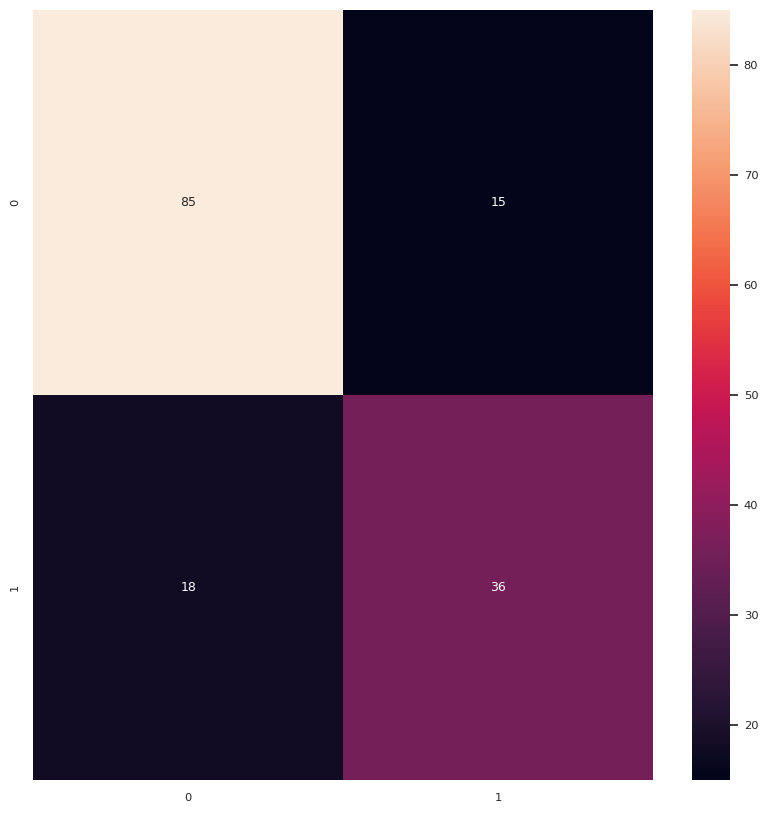

In [48]:
# printing the confusion metric for Random Forest

plt.figure(figsize = (10, 10))
RF_cf = confusion_matrix(y_test, RF_predict)
sns.heatmap(RF_cf, annot = True)
plt.show()

The best algorithm for this data was Naive Bayes, followed closely by Logistic Regression, and then, also, with almost the same score, decision trees, and SVM.